# Local image operators
### Box Filter
Operator used for finding the sums of the elements.
$$ g(i,j) = \frac{1}{KL} \sum_{k,l} I(i-k, j-l)$$
where $K$ and $L$ is the size of the filter, $I$ - image.

In [11]:
import numpy as np
def convolve(img, kernel):
    
    rows = img.shape[0];
    cols = img.shape[1];
    res = np.zeros((img.shape[0], img.shape[1]));
    # going over every pixel of the original image
    for r in range(0, rows):
        for c in range(0, cols):
#             print("r:",r, "c:",c)
            s = 0;
            # going over pixels of the kernel
            kernel_rows = kernel.shape[0]
            kernel_cols = kernel.shape[1]
            v = kernel_rows // 2;
            for kr in range(-v, v+1):
                for kc in range(-v, v+1):
                    ## border conditions
                    if ( (r+kr) < 0 or (r+kr) >= rows or (c+kc) < 0 or (c+kc) >= cols):
                        continue;
#                     print("kern. r:", r+kr, "c:", c+kc)
                    s = s + kernel[kr + v, kc + v]* img[r + kr, c + kc];
            res[r][c] = s;
    
    return res

In [12]:
## Testing general convolution with box filter
print("Testing box filter with general convolution")
img1 = np.zeros((5,5))
img1[2,2] = 5;
print("Image 1  \n", img1)
ker = (np.zeros((3,3))+1)

## box filter
print("Box filter full")
res1 = convolve(img1, ker)
print(res1)

## Example 2
print(" == Example 2 ==")
img2 = np.array([[0.0, 1, 0, 2], [0,1,3,1], [1, 0, 0,2]])
print("Test image\n", img2)
print("Box filter full")
img2_conv = convolve(img2, ker)
print(img2_conv)


Testing box filter with general convolution
Image 1  
 [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 5. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
Box filter full
[[0. 0. 0. 0. 0.]
 [0. 5. 5. 5. 0.]
 [0. 5. 5. 5. 0.]
 [0. 5. 5. 5. 0.]
 [0. 0. 0. 0. 0.]]
 == Example 2 ==
Test image
 [[0. 1. 0. 2.]
 [0. 1. 3. 1.]
 [1. 0. 0. 2.]]
Box filter full
[[ 2.  5.  8.  6.]
 [ 3.  6. 10.  8.]
 [ 2.  5.  7.  6.]]


# Implementing box filter using integral images
## Computing integral image
Given an image an integral image stores the sum of all the value to the left and up from the given cell.

Since box filter computer the sum over the area of the  in the image, we can use integral image to speed up the computations. The main idea is to use the values stored in the integral image to  compute the sum.
For example, if we want to compute what would the sum be for the kernel of size 3 in the position $[r,c]$, then we need to use corresponding entries of the integral image.


$$ sum = x - a - b + c $$

The corresponding values are located in the following cells with respect to the center (r,c) of the placed kernel  

$ i,j = [r + h/2], [c + h/2]$   
$ x= In[i,j]$  
$ a = In[i][j - h]$  
$ b = In[i - h][j]$      
$ c = In[i - h][j -h]$   
where In is an integral image and h width of the kernel. Here kernel are only squared.

Special care should be taken with border conditions.
**ERROR** in the below image r should be r = a+b-c+x.

![image_name](data/Convolution.png)

In [13]:
import copy
## Implementing box filter using intergral images
def computeIntegralImage(img):
    int_img = copy.deepcopy(img)
    for r in range(int_img.shape[0]):
        for c in range(int_img.shape[1]):
            if r ==0 and c == 0:
                int_img[r,c] = img[r,c]
                continue
            if r == 0:
                int_img[r,c] =  int_img[r, c-1] + img[r,c]
                continue
            if c == 0:
                int_img[r,c] = int_img[r-1,c] + img[r,c]
                continue;
            int_img[r,c] = int_img[r-1,c] + int_img[r, c-1] - int_img[r-1, c-1] + img[r,c]
    return int_img

## box filter through integral image
## assumes that the kernel is all 1.
def convolveBox(img, kernel_size):
    int_img = computeIntegralImage(img)
    res = np.zeros((img.shape))
    ## going over int_img
    h = kernel_size
    rows = int_img.shape[0]
    cols = int_img.shape[1]
    v = h // 2; ## shift to the center of the kernel
    for i in range(rows):
        for j in range(cols):
            ## shifting from the center of kernel to bottom right corner
            x_row = i + v
            x_col = j + v
            
            a_row = x_row
            a_col = x_col - h
            
            b_row = x_row - h
            b_col = x_col
            
            c_row = x_row - h
            c_col = x_col - h
            
#             print("b", b_row," ", b_col)
            
            ## checking c
            if ( c_col < 0 or c_row < 0):
                c = 0
            else:
                c = int_img[c_row, c_col]
                
            ## checking b
            if (b_row < 0):
                b = 0
            elif (b_col >= cols):
                b = int_img[b_row, cols-1]
            else:
                b = int_img[b_row, b_col]
                
            ## checking a
            if (a_col < 0):
                a = 0;
            elif (a_row >= rows):
                a = int_img[rows - 1, a_col]
            else:
                a = int_img[a_row, a_col]
        
            ## checking x
            if x_col >= cols and x_row >= rows:
                x = int_img[rows-1, cols-1]
            elif  x_col >= cols:
                x = int_img[x_row, cols-1];
            elif x_row >= rows:
                x = int_img[rows -1, x_col]
            else:
                x = int_img[x_row, x_col]
#             print("i", i, "j", j)
#             print("x ", x, "a ", a, " b", b, "c", c)
            res[i, j] = x - a - b + c; 
    return res;
    

In [14]:
## checking with integral image
## check computing of integral image
int1 = computeIntegralImage(img1)
print("Integral image 1\n", int1)
int2 = computeIntegralImage(img2)
print("Integral image 2\n", int2)

## seems that integral image working

print("Box filter int")
res_int2 = convolveBox(img2, 3)
print(res_int2)



Integral image 1
 [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 5. 5. 5.]
 [0. 0. 5. 5. 5.]
 [0. 0. 5. 5. 5.]]
Integral image 2
 [[ 0.  1.  1.  3.]
 [ 0.  2.  5.  8.]
 [ 1.  3.  6. 11.]]
Box filter int
[[ 2.  5.  8.  6.]
 [ 3.  6. 10.  8.]
 [ 2.  5.  7.  6.]]


# Applying Binomial, Box and Sobel filter

Test image
 [[0. 1. 0. 2.]
 [0. 1. 3. 1.]
 [1. 0. 0. 2.]]
<class 'numpy.float64'>


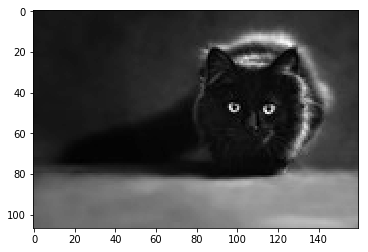

In [15]:
import cv2
import matplotlib.pyplot as plt

## Loading data

## Test image
test_img = np.array([[0.0, 1, 0, 2], [0,1,3,1], [1, 0, 0,2]])
print("Test image\n", test_img)

## Real image
# img_name = "data/cat_rusty.jpg";
img_name = "data/cat_black_small.jpg"
# img_name = "data/starry_night_small.jpg"
image = cv2.imread(img_name, 0);
image = image.astype('float')
print(type(image[0,0]))
plt.imshow(image, cmap='gray');



Box filter convolution


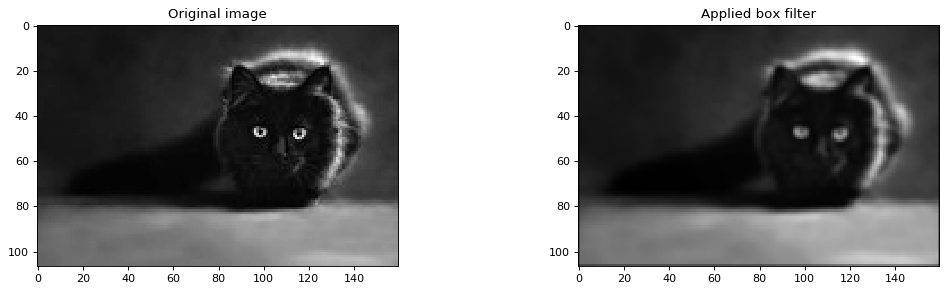

In [16]:

print("Box filter convolution")
# res_boxfilter = convolveBox(test_img, 3)
# print(res_boxfilter)

## Box filter on image
box_ker = (np.zeros((3,3))+1)
# res_image_box = convolve(image, box_ker) / 9
res_image_box = convolveBox(image, 3) / 9
## plotting
fig=plt.figure(figsize=(16, 4), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(121)
plt.imshow(image, cmap="gray")
plt.title("Original image");

plt.subplot(122)
plt.imshow(res_image_box, cmap="gray")
plt.title("Applied box filter");


In [17]:
### Binomial filter on test image
print("Binomial filter ")
# convolving with B_4^2
# bin_filter = np.array([[1, 4, 6, 4, 1], [4, 16, 24, 16, 4], [6,24,36,24,6], [4, 16, 24, 16, 4], [1, 4, 6, 4, 1] ])
# res_bin = convolve(test_img, bin_filter) / 256
## Convolving wuth B_2^2 filter
bin_filter = np.array([[1, 2, 1], [2,4,2], [1,2,1]])
res_bin = convolve(test_img, bin_filter)/16

print(res_bin)


Binomial filter 
[[0.1875 0.5625 0.875  0.8125]
 [0.3125 0.8125 1.3125 1.125 ]
 [0.3125 0.4375 0.75   0.8125]]


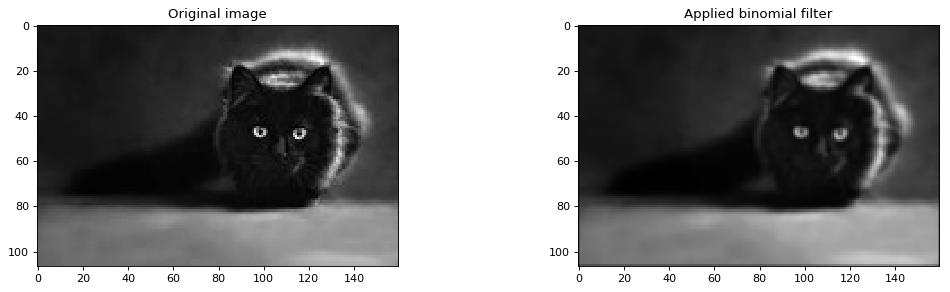

In [18]:
### Binomial filter on an image
res_image_bin = convolve(image, bin_filter) /16
## plotting
fig=plt.figure(figsize=(16, 4), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(121)
plt.imshow(image, cmap="gray")
plt.title("Original image");

plt.subplot(122)
plt.imshow(res_image_bin, cmap="gray")
plt.title("Applied binomial filter");


### Checking the difference between Binomial and Box kernel

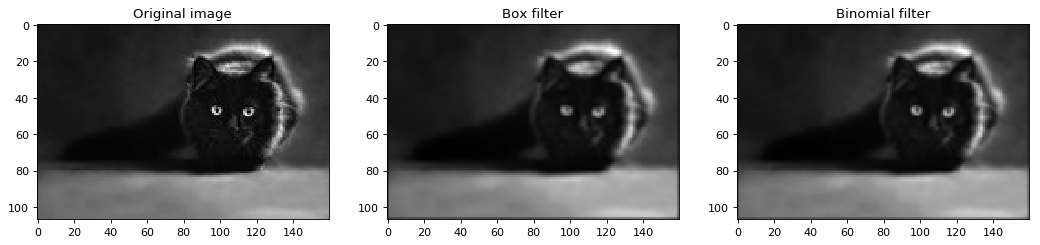

In [19]:
## plotting
fig=plt.figure(figsize=(16, 4), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(131)
plt.imshow(image, cmap="gray")
plt.title("Original image");

plt.subplot(132)
plt.imshow(res_image_box, cmap="gray")
plt.title("Box filter");

plt.subplot(133)
plt.imshow(res_image_bin, cmap="gray")
plt.title("Binomial filter");

X derivative 
 [[-0.125 -0.625 -1.    -0.625]
 [-0.125  0.125  0.125  0.   ]
 [ 0.125  0.625  1.     0.625]]
Y derivative 
 [[-0.375 -0.375 -0.25   0.375]
 [-0.375 -0.625 -0.375  0.75 ]
 [-0.125 -0.125 -0.5    0.375]]
Gradient
 [[0.39528471 0.72886899 1.03077641 0.72886899]
 [0.39528471 0.63737744 0.39528471 0.75      ]
 [0.1767767  0.63737744 1.11803399 0.72886899]]


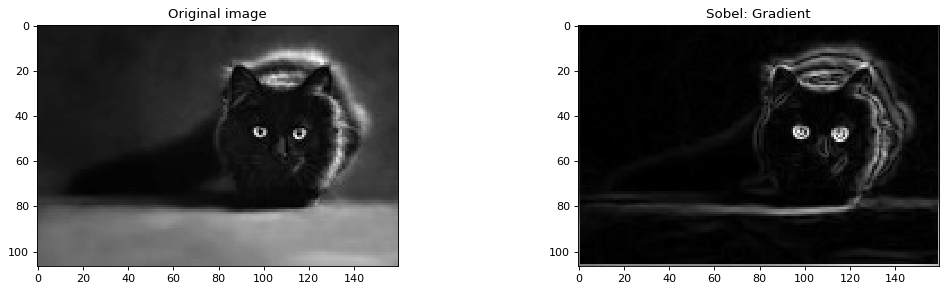

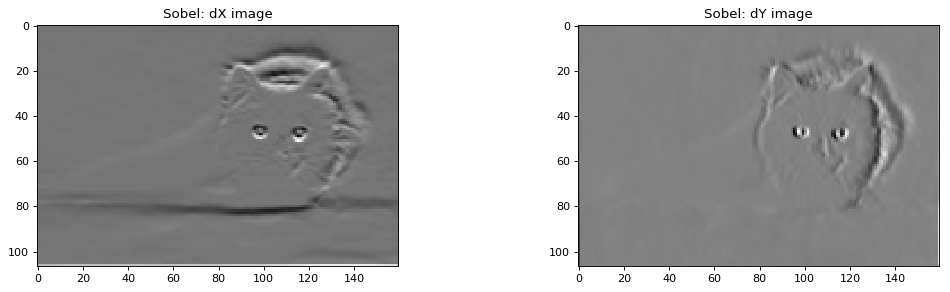

In [20]:
### Applying Sobel filter

## test image
dx_kernel = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]]) # over rows
dy_kernel = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]]) # over columns

dx_image_test = convolve(test_img, dx_kernel) / 8
dy_image_test = convolve(test_img, dy_kernel) / 8
res_image_test = np.sqrt(np.square(dx_image_test) + np.square(dy_image_test))
print("X derivative \n", dx_image_test)
print("Y derivative \n", dy_image_test)
print("Gradient\n", res_image_test)

## real image
dx_image = convolve(image, dx_kernel) / 8
dy_image = convolve(image, dy_kernel) / 8

res_image = np.sqrt(np.square(dx_image) + np.square(dy_image))

## plotting
plt.figure(figsize=(16, 4), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(121)
plt.imshow(image, cmap="gray")
plt.title("Original image");

plt.subplot(122)
plt.imshow(res_image, cmap="gray")
plt.title("Sobel: Gradient");

plt.figure(figsize=(16, 4), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(121)
plt.imshow(dx_image, cmap="gray")
plt.title("Sobel: dX image");

plt.subplot(122)
plt.imshow(dy_image, cmap="gray")
plt.title("Sobel: dY image");
